# Active Learning for Text Classification using Small-Text
## 01 - Introduction

This tutorial shows how to use [small-text](https://github.com/webis-de/small-text) to perform active learning for text classification using state-of-the-art transformer models.


### Installation

Besides small-text, we also install [datasets](https://github.com/huggingface/datasets) to load an example dataset and [matptlotlib](https://matplotlib.org/) to plot the learning curves at the end.

In [1]:
%pip install small-text[transformers]==1.0.0b3  # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Preparation

Here we configure the loggging and display progress bars display of the `datasets` library to improve its appearance in the notebook. You can skip this when reading for the first time if you are only interested in active learning.

In [2]:
import datasets
datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Moreover, we update the default matplotlib settings to receive a more visually appealing plot at the end of this tutorial.

In [3]:
from matplotlib import rcParams
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

Finally, we will fix the random seeds so that readers do not get confused when the results change upon repeated execution.

In [4]:
import torch
import numpy as np

seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

### Loading the Data

First we load rotten tomatoes dataset. This dataset contains movie reviews sentences, which are labeled by their sentiment as either positive or negative.

In [5]:
import logging

raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

  0%|          | 0/3 [00:00<?, ?it/s]

First 10 training samples:

1   the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
1   the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
1   effective but too-tepid biopic
1   if you sometimes like to go to the movies to have fun , wasabi is a good place to start .
1   emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .
1   the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
1   offers that rare combination of entertainment and education .
1   perhaps no picture ever made has more literally showed that the road to hell is paved with good inten

### Preparing the Data

Next, we have to convert this raw text data into a format usable by small-text. Since the transformer-based classification in small-text uses huggingface transformers this step is pretty similar to the preprocessing you may know from transformers, with the addition that the end result must be a `TransformersDataset`. In this example, we use `bert-base-uncased` as transformer model.

In [6]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    
    transformer_model_name
)

We define a small helper function `get_transformers_dataset()` with delegates to `tokenizer.encode_plus()` and finally builds a `TransformersDataset` instance. 

In [7]:
from small_text.integrations.transformers.datasets import TransformersDataset


def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)


train = get_transformers_dataset(tokenizer, raw_dataset['train']['text'], raw_dataset['train']['label'])
test = get_transformers_dataset(tokenizer, raw_dataset['test']['text'], raw_dataset['test']['label'])

### Setting up the Active Learner

Now we constrauct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 10 sentences. This corresponds to an initial labeling the real-world setting.

In [8]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.integrations.transformers import TransformerModelArguments


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial



transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

loglikelihood_err: 
tensor([[0.3920],
        [0.6404],
        [0.3854],
        [0.5957],
        [0.4557],
        [0.5929],
        [0.6681],
        [0.6287],
        [0.6044],
        [0.6492],
        [0.6367],
        [0.3358],
        [0.3496],
        [0.3695],
        [0.3554],
        [0.3413],
        [0.2737],
        [0.6625]], device='cuda:0', grad_fn=<SumBackward1>)
loglikelihood_var: 
tensor([[0.1514],
        [0.1412],
        [0.1503],
        [0.1549],
        [0.1612],
        [0.1552],
        [0.1448],
        [0.1504],
        [0.1537],
        [0.1401],
        [0.1493],
        [0.1406],
        [0.1434],
        [0.1473],
        [0.1446],
        [0.1418],
        [0.1259],
        [0.1456]], device='cuda:0', grad_fn=<SumBackward1>)
KL: 
tensor([[0.0000],
        [0.0514],
        [0.0000],
        [0.0159],
        [0.0000],
        [0.0150],
        [0.0446],
        [0.0275],
        [0.0187],
        [0.0556],
        [0.0307],
        [0.0000],
       

### Active Learning Loop

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next.
We then provide the labels for those documents and the active learner retrains the model.
After each query, we evaluate the current model against the test set and save the result.


Note: This is active learning as it is done in a scientific simulation. In reality, the label feedback would have been given by human annotators, and moreover, we would not be able to measure the test accuracy.

In [9]:
from sklearn.metrics import accuracy_score


num_queries = 10


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))


Train accuracy: 0.65
Test accuracy: 0.49
loglikelihood_err: 
tensor([[0.5977],
        [0.5000],
        [0.4118],
        [0.5569],
        [0.5481],
        [0.5508],
        [0.4272],
        [0.5488],
        [0.5000],
        [0.5000],
        [0.5826],
        [0.4492],
        [0.4771],
        [0.4182],
        [0.5000],
        [0.6260],
        [0.5389],
        [0.6515],
        [0.6057],
        [0.5000],
        [0.5000],
        [0.6473],
        [0.5000],
        [0.4971],
        [0.5863],
        [0.3992],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.6320],
        [0.7850],
        [0.5458]], device='cuda:0', grad_fn=<SumBackward1>)
loglikelihood_var: 
tensor([[0.1546],
        [0.1667],
        [0.1547],
        [0.1599],
        [0.1610],
        [0.1607],
        [0.1571],
        [0.1609],
        [0.1667],
        [0.1667],
        [0.1566],
        [0.1603],
        [0.1640],
        [0.1558],
        [0.1667],
        [0.1507],
        [0.16

KeyboardInterrupt: 

### Plotting the Results

Using the previously saved results we can plot a [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to visualize the resulting accuracy on the test set.

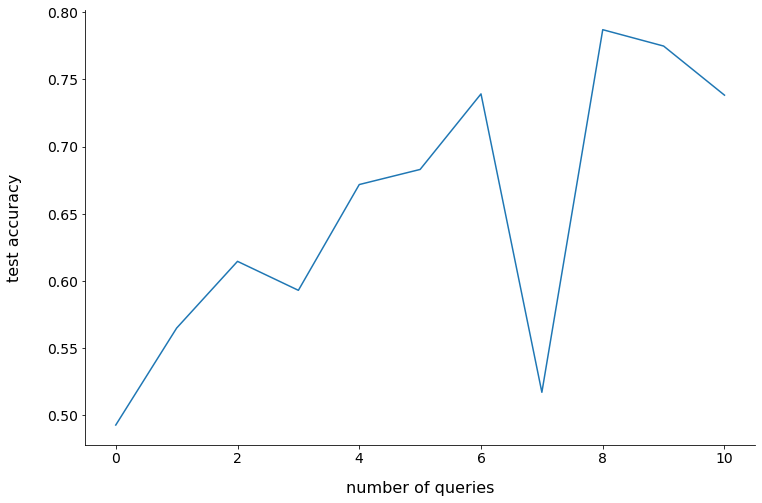

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('test accuracy', labelpad=25)

sns.despine()